<a href="https://colab.research.google.com/github/tiwarylab/AF2RAVE_Glide-kinase/blob/main/2_SPIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mdtraj

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md
import pickle
import glob
import sys
sys.path.append('/content/drive/MyDrive/AF2RAVE-Glide/kinase_Aloop/')
import kinaseCVs as kcv
from kinaseCVs import resids_DDR1

In [ ]:
def spib_color(spib_labels):
  cmap = matplotlib.colormaps["tab20"]
  c_array=np.where(np.reshape(spib_labels,(spib_labels.shape[0]*spib_labels.shape[1],spib_labels.shape[2]))==1)[1]
  sets=list(set(c_array))
  color_dict={}
  for i in range(len(sets)):
    color_dict[sets[i]]=i
  color_array=[color_dict[col] for col in c_array];
  return color_array

def labels_int_to_str(labels):
  label_dict={1:'DFG_in', 2:'Unassigend', -1:'DFG_out', 0:'DFG_inter'}
  labels_str=[label_dict[label] for label in labels]
  return labels_str

def get_dfglabel(d1,d2):
  labels=2*np.ones(d1.shape[0])
  ind1=np.where(d1<=1.1)[0]
  labels[ind1]=1
  ind2=np.where(d2[ind1]<=1.1)[0]
  labels[ind1[ind2]]=0
  ind3=np.where(d1>1.1)[0]
  ind4=np.where(d2[ind3]<=1.4)[0]
  labels[ind3[ind4]]=-1
  return labels

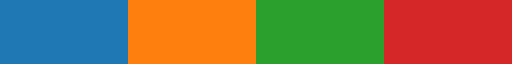

In [ ]:
colors = [plt.cm.tab10(0),plt.cm.tab10(1),plt.cm.tab10(2),plt.cm.tab10(3)]
cmap=matplotlib.colors.ListedColormap(colors)
cmap

In [ ]:
kinase = 'DDR1'
listindices=['ini_1074','ini_1102','ini_122','ini_1','ini_459','ini_4','ini_644','ini_776','ini_888','ini_916','ini_943','ini_961']

In [ ]:
round = '/content/drive/MyDrive/AF2RAVE-Glide/SPIB_std_filter/round1'
op_id = [int(x) for x in np.loadtxt(f'{round}/op_id.txt')]
op_id

[1, 2, 3, 7, 8, 10, 11, 12]

In [ ]:
# ls = []
# for i in range(len(listindices)):
#     ls.append(np.loadtxt(f"/content/drive/MyDrive/AF2RAVE-Glide/unbiased/{kinase}/{listindices[i]}/prodrun_NPT_0_dists.txt")[::10,op_id])

# ls_array=np.array(ls)
# ls_array=np.reshape(ls_array,(ls_array.shape[0]*ls_array.shape[1],ls_array.shape[2]))

# cvs=[]
# for i in range(len(listindices)):
#     cvs.append(np.loadtxt(f"/content/drive/MyDrive/AF2RAVE-Glide/unbiased/{kinase}/{listindices[i]}/prodrun_NPT_0_dists.txt")[::10])
# cvs_array=np.array(cvs)
# cvs_array=np.reshape(cvs_array,(cvs_array.shape[0]*cvs_array.shape[1],cvs_array.shape[2]))
# labels_dfg=get_dfglabel(cvs_array[:,-3],cvs_array[:,-2])

cvs=[]
sb_array = []
labels_dfg = []
for i in range(len(listindices)):
    traj_top = md.load(f"/content/drive/MyDrive/AF2RAVE-Glide/unbiased/{kinase}/{listindices[i]}/prodrun_NPT_0.pdb")
    protein_selection = traj_top.top.select("protein")
    protein_topology = traj_top.top.subset(protein_selection)
    traj = md.load(f"/content/drive/MyDrive/AF2RAVE-Glide/unbiased/{kinase}/{listindices[i]}/prodrun_NPT_0.xtc", top=protein_topology)
    sb = kcv.SB_CB_chodera(resids_DDR1,traj.top,traj).traj
    sb_array.append(sb[::2])

    cv = kcv.kinase_cvs("DDR1",traj.top,resids_DDR1,traj)
    CVs = []
    for i in range(len(cv.allcvs)):
        CVs.append(cv.allcvs[i].traj)
    CVs = np.transpose(CVs)
    labels_dfg.append(get_dfglabel(CVs[::2,-3],CVs[::2,-2]))
    cvs.append(CVs[::2,op_id])
sb_array = np.concatenate(sb_array)
cvs_array=np.array(cvs)
cvs_array=np.reshape(cvs_array,(cvs_array.shape[0]*cvs_array.shape[1],cvs_array.shape[2]))
labels_dfg = np.concatenate(labels_dfg)

In [ ]:
op_max = np.load(f"{round}/{kinase}_input/max_unb.npy")
op_min = np.load(f"{round}/{kinase}_input/min_unb.npy")
lag = 8000
dt = f"{lag*2e-3} ns"
prefix=f"{round}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_b=0.0500_learn=0.000100_"
weights=np.load(prefix+"z_mean_encoder_weight0.npy")

n_weights = weights/(op_max-op_min)
md_array = np.dot(cvs_array, n_weights.T)

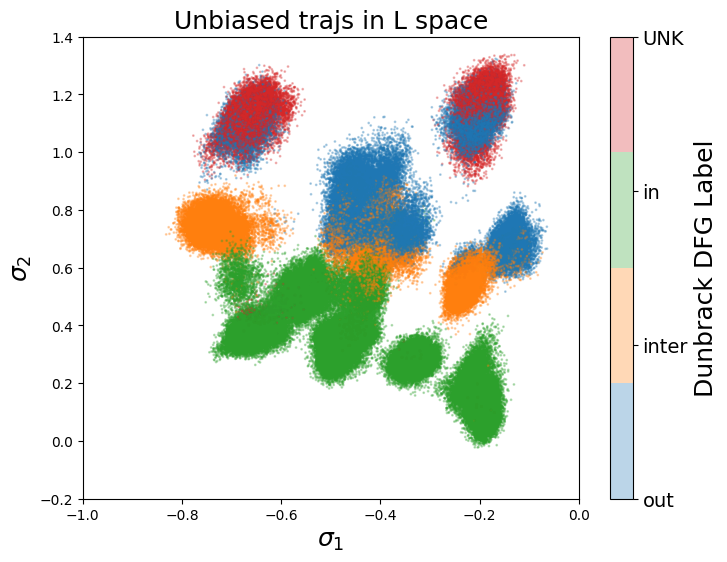

In [ ]:
plt.figure(figsize=(8, 6))

plot = plt.scatter(md_array.T[0],md_array.T[1],c=labels_dfg,s=1,alpha=0.3,cmap=cmap)
plt.title('Unbiased trajs in L space',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1$",fontsize=18)
plt.ylabel("$\sigma_2$",fontsize=18)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
cbar = plt.colorbar(plot, ticks=[-1, 0, 1, 2])
cbar.set_label(label='Dunbrack DFG Label',size=18)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticklabels(['out', 'inter', 'in', 'UNK'])
plt.savefig("SPIB_DFG.png",dpi=300)

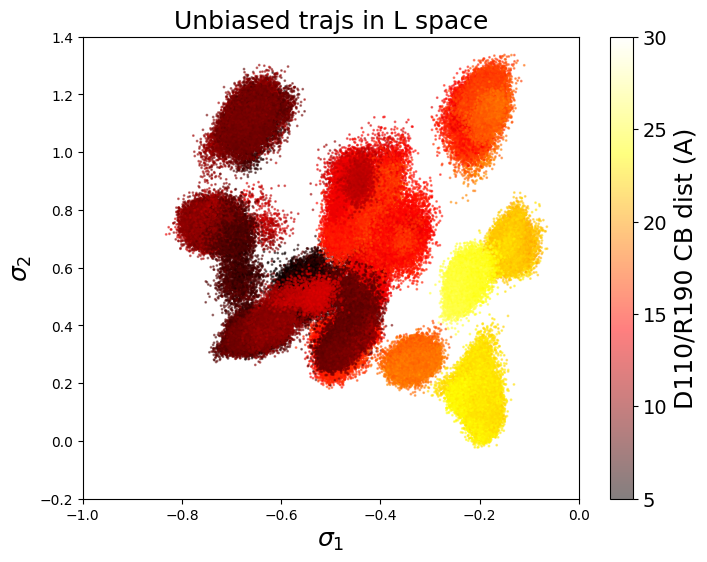

In [ ]:
plt.figure(figsize=(8, 6))

plot=plt.scatter(md_array.T[0],md_array.T[1],s=1,alpha=0.5,c=sb_array*10, cmap='hot', vmin=5, vmax=30)
plt.title('Unbiased trajs in L space',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1$",fontsize=18)
plt.ylabel("$\sigma_2$",fontsize=18)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
cbar = plt.colorbar(plot)
cbar.set_label(label='D110/R190 CB dist (A)',size=18)
cbar.ax.tick_params(labelsize=14)
plt.savefig(f"SPIB_sb.png",dpi=300)